In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /var/folders/73/0j93mrvd1s77hv6p1fbfrqz80000gn/T/matplotlib-smpnusiz because the default path (/Users/anatlevari/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Understand the dataset

In this notebook, the dataset of heartfailure is examined. A classification task can be found on the next notebook - "Heart Failure Classifiction".

In [2]:
df = pd.read_csv('/Users/anatlevari/Downloads/heart.csv')

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.describe() # Distribution of numerical features

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
df.describe(include=['O']) # Distribution of catagorial features

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
display(df.shape)

(918, 12)

## Data check

In [8]:
# identify the Data Types - Numpy
df_dd = pd.DataFrame(df.dtypes,columns=['Numpy Dtype'])

# identify the unique values
df_dd['Nunique'] = df.nunique()

# identify the Missing values
df_dd['MissingValues']=df.isnull().sum()

# identify the count for each variable
df_dd['Count']=df.count()

# identify the zero values for each variable
df_dd['ZeroValues']=(df==0).sum()

df_dd

,Numpy Dtype,Nunique,MissingValues,Count,ZeroValues
Age,int64,50,0,918,0
Sex,object,2,0,918,0
ChestPainType,object,4,0,918,0
RestingBP,int64,67,0,918,1
Cholesterol,int64,222,0,918,172
FastingBS,int64,2,0,918,704
RestingECG,object,3,0,918,0
MaxHR,int64,119,0,918,0
ExerciseAngina,object,2,0,918,0
Oldpeak,float64,53,0,918,368


This shows that the data is clean and there are no missing values.

## Outliers check using z-score:

In [9]:
# preparing only numeric values to check
cal_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_df = df.drop(cal_cols, axis=1)

# calculating z-score and find values where z>3 - outliers
z = np.abs(stats.zscore(numeric_df))
print(np.where(z > 3))
print(np.shape(np.where(z > 3)))

(array([ 76, 109, 149, 166, 241, 324, 365, 390, 399, 449, 592, 616, 702,
       732, 759, 771, 791, 850, 900]), array([2, 1, 2, 5, 1, 5, 1, 4, 1, 1, 1, 2, 5, 1, 1, 5, 5, 5, 5]))
(2, 19)


There are 19 outliers in the data. The outliers can be found in 4 features corresponding to the columns of the numeric dataframe: 
- column 1: RestingBP
- column 2: Cholesterol
- column 4: MaxHR
- column 5: Oldpeak

The next step is to determine what to do with the outliers. For that purpose, the dataset examination section above is used:
- Regarding RestingBP outliers - their values are above 180 mmHg and people with such values should seek emergency care. Since the data collection process is not clear, I will consider them as outliers that should be removed.  
- Regarding cholesterol levels - The outliers found using z-score are those with very high values of cholesterol. One can also see that the max cholesterol level in the dataset is 603 ml. It is possible to have such high cholesterols and thus the outliers corresponding to high cholesterol column won't be considered as such and won't be removed/fixed. In addition, removal of zero values of cholesterol is required. 

An examination of the other outliers: 

In [10]:
# Max Heart Rate outlier values
print(f"The value of the outlier corresponding to the MaxHR is {numeric_df.loc[390][4]}") 
print(f"This sample has a heart failure value of {numeric_df.iloc[390,-1]}")

# check an outlier correspond to the Oldpeak column:
print(f"A value of an outlier corresponding to OldPeak: {numeric_df.loc[900][5]}") 
print(f"This sample has a heartfailure value of {numeric_df.iloc[900,-1]}")

The value of the outlier corresponding to the MaxHR is 60.0
This sample has a heart failure value of 1
A value of an outlier corresponding to OldPeak: 4.4
This sample has a heartfailure value of 1


As can be seen, the oulier which corresponds to the maxHR has a nurmal (low) heart rate and thus won't be considered as an outlier. The Oldpeak values will be considered as outliers that should be removed at this point. Further investigation into these values is required in the future.

### Outliers Removal:

In [11]:
outliers_arr = np.where(z > 3)
outliers_rows = outliers_arr[0]
outliers_cols = outliers_arr[1]

rows2delete = []
# taking the rows to delete, corresponding to the columns 1 (RestingBP) and 5 (Oldpeak)
for i in range(len(outliers_cols)):
    if (outliers_cols[i] == 1) or (outliers_cols[i] == 5):
        rows2delete.append(i) 

# dropping those rows 
df_clean = df.drop(df.index[rows2delete])        

# find and remove zero cholesterol rows:
df_clean = df_clean[(df_clean['Cholesterol'] != 0)]

# import the new DataFrame to be used in the classification task in next notebook
df_clean.to_csv('/Users/anatlevari/Downloads/heart_clean.csv', index=False)


## Univariant Analysis

### Heart Disease Examination

In [12]:
# find heartdeseas ratio 
num_heartdiseas = df_clean[df_clean['HeartDisease'] == 1].count()[0]
num_not_heartdiseas = df_clean[df_clean['HeartDisease'] == 0].count()[0]
number_of_samples = df_clean.count()[0]

print('Number of samples having heart failure/ total number of samples:', num_heartdiseas, '/' ,number_of_samples)
print('Number of samples NOT having heart failure/ total number of samples:', num_not_heartdiseas, '/', number_of_samples)
print('The ratio - have/(not have):', 
         round((num_heartdiseas/number_of_samples) * 100, 2), '/', 
           round((num_not_heartdiseas/number_of_samples) * 100, 2))


Number of samples having heart failure/ total number of samples: 350 / 731
Number of samples NOT having heart failure/ total number of samples: 381 / 731
The ratio - have/(not have): 47.88 / 52.12


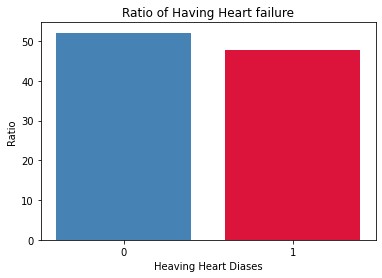

In [13]:
# plot the above ratio
ax = plt.bar(['0', '1'], 
          [round((num_not_heartdiseas/number_of_samples) * 100, 2), round((num_heartdiseas/number_of_samples) * 100, 2)],
           color = ['steelblue', 'crimson'])


plt.xlabel("Heaving Heart Diases")
plt.ylabel("Ratio")
plt.title("Ratio of Having Heart failure")

plt.show()

From the above calculation, one can see the data is not biased.

### Other numerical features examination

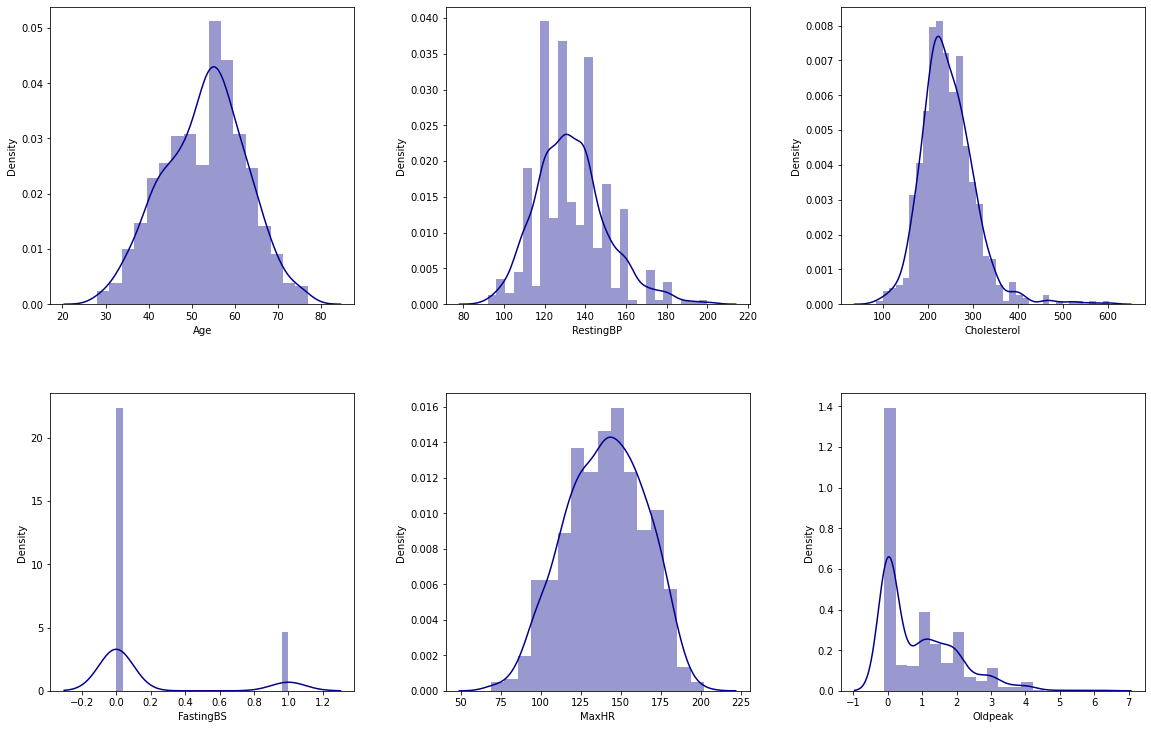

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,5))

g = sns.distplot(df_clean['Age'],ax=axes[0,0], color='darkblue')
g = sns.distplot(df_clean['RestingBP'],ax=axes[0,1], color='darkblue')
g = sns.distplot(df_clean['Cholesterol'],ax=axes[0,2], color='darkblue')
g = sns.distplot(df_clean['FastingBS'],ax=axes[1,0], color='darkblue')
g = sns.distplot(df_clean['MaxHR'],ax=axes[1,1], color='darkblue')
g = sns.distplot(df_clean['Oldpeak'],ax=axes[1,2], color='darkblue')

plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=2, wspace=0.3, hspace=0.3)

### Distribution of catagorial features

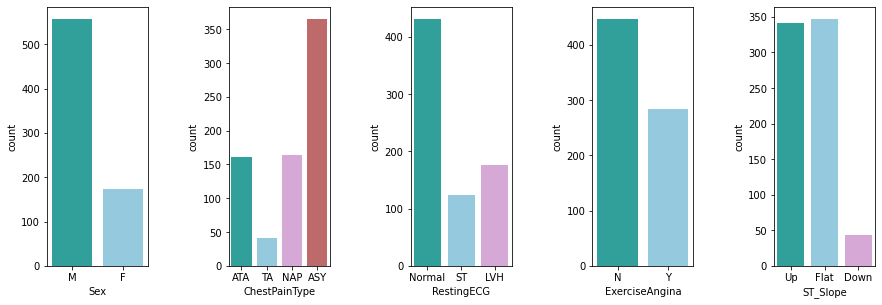

In [15]:
fig, axes = plt.subplots(ncols=5,figsize=(20,6))

g = sns.countplot(df_clean["Sex"], ax=axes[0], palette = ['lightseagreen', 'skyblue'])
g = sns.countplot(df_clean["ChestPainType"], ax=axes[1], palette = ['lightseagreen', 'skyblue', 'plum', 'indianred'])
g = sns.countplot(df_clean["RestingECG"], ax=axes[2], palette = ['lightseagreen', 'skyblue', 'plum'])
g = sns.countplot(df_clean["ExerciseAngina"], ax=axes[3], palette = ['lightseagreen', 'skyblue'])
g = sns.countplot(df_clean["ST_Slope"], ax=axes[4], palette = ['lightseagreen', 'skyblue', 'plum'])

axes[0].plot()
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.7, top=0.7, wspace=0.8, hspace=None)


Insights:
Uneven distribution of the features. Mainly in:
- 'ChestPainType' - TA/ASY
- 'ST_Slope' - Flat/Down.

For later, need to verify these features distributed correctly in the classification process.


### Further lookout into the correlation of 'Sex' and 'having Heart Disease'

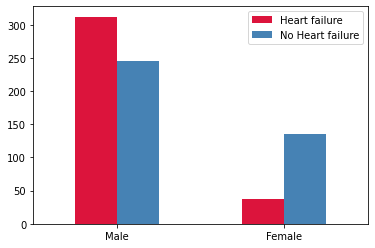

In [16]:
# creating sub data frame where the Male and Female colums are separated, according to HeartDisease
dfSvsHeart = df_clean[['Sex', 'HeartDisease']]

Num_of_Positive_Male = dfSvsHeart[(dfSvsHeart['Sex'] == 'M') & (dfSvsHeart['HeartDisease'] == 1)].shape[0]
Num_of_Positive_Female = dfSvsHeart[(dfSvsHeart['Sex'] == 'F') & (dfSvsHeart['HeartDisease'] == 1)].shape[0]

Num_of_Negative_Male = dfSvsHeart[(dfSvsHeart['Sex'] == 'M') & (dfSvsHeart['HeartDisease'] == 0)].shape[0]
Num_of_Negative_Female = dfSvsHeart[(dfSvsHeart['Sex'] == 'F') & (dfSvsHeart['HeartDisease'] == 0)].shape[0]

Positive = [Num_of_Positive_Male, Num_of_Positive_Female]
Negative = [Num_of_Negative_Male, Num_of_Negative_Female]

index = ['Male', 'Female']
df4SvsHeart = pd.DataFrame({'Heart failure': Positive, 'No Heart failure': Negative}, index=index)

ax = df4SvsHeart.plot.bar(rot=0, color = ['crimson', 'steelblue'])

The higher ratio of heart disease in men observed above corresponds to the current research. 

### Further lookout into the correlation of 'Age' and 'having HeartDisease'

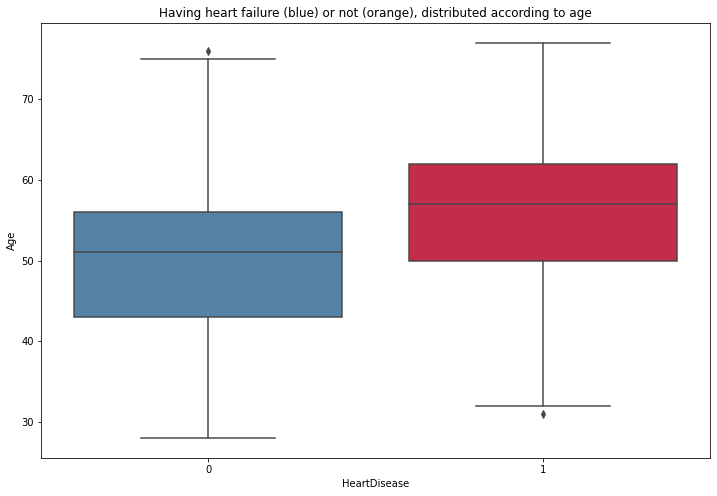

In [17]:
fig = plt.figure()
fig.set_size_inches(12, 8)
my_pal = ["orange", "blue"]
sns.boxplot( x='HeartDisease', y='Age', data=df_clean, palette = ['steelblue', 'crimson'])
plt.title("Having heart failure (blue) or not (orange), distributed according to age")
plt.show()

From the above, the age of the group having heart failure is bigger, and tighter around the mean. This corresponds to the current research. 
Note that the average age of having heart failure is less than 60, which is younger that the average age in the  general population. This is due to the fact that this dataset is composed of samples of people who already have cardiovascular disease or at high cardiovascular risk and thus are prone to heart failure.

This relationship can be viewed also using histograms:

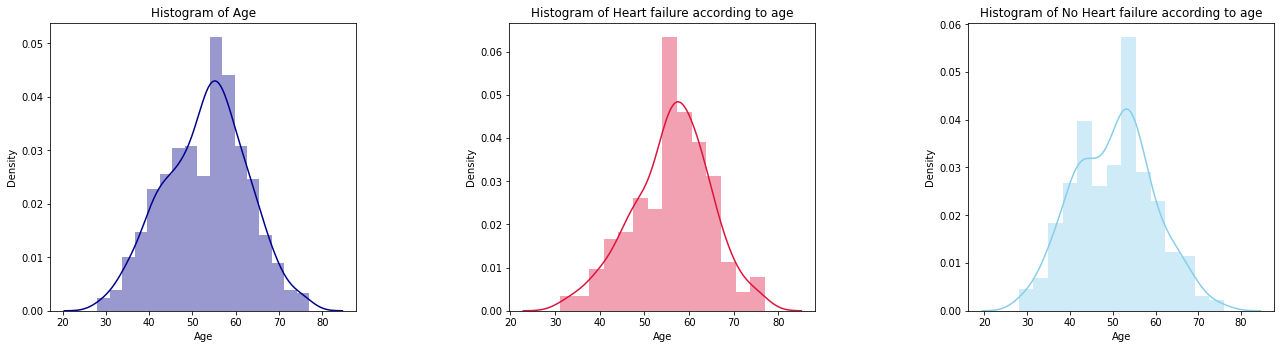

In [18]:
# histograms for the age/heartdeseas relashionship

fig, axes = plt.subplots(ncols=3, figsize=(10,5))


# creating new dataframes for each case
dfAgeHeart = df_clean[['Age', 'HeartDisease']]
dfAge_has_HeartD = dfAgeHeart[dfAgeHeart['HeartDisease'] == 1]
dfAge_not_HeartD = dfAgeHeart[dfAgeHeart['HeartDisease'] == 0]

# histograms and density
g = sns.distplot(a=df_clean['Age'], color = 'darkblue', ax=axes[0])
g = sns.distplot(a=dfAge_has_HeartD['Age'], color = 'crimson', ax=axes[1])
g = sns.distplot(a=dfAge_not_HeartD['Age'], color = 'skyblue', ax=axes[2])

# adjusting
axes[0].set_title('Histogram of Age')
axes[1].set_title('Histogram of Heart failure according to age')
axes[2].set_title('Histogram of No Heart failure according to age')
plt.subplots_adjust(left=0.1, bottom=0.8, right=1.8, top=1.6, wspace=0.5, hspace=None)

plt.show()




## Multivariate Analysis

We observe the correlation graphs between each two features. The plot also contains histograms on the diagonal.

<Figure size 432x288 with 0 Axes>

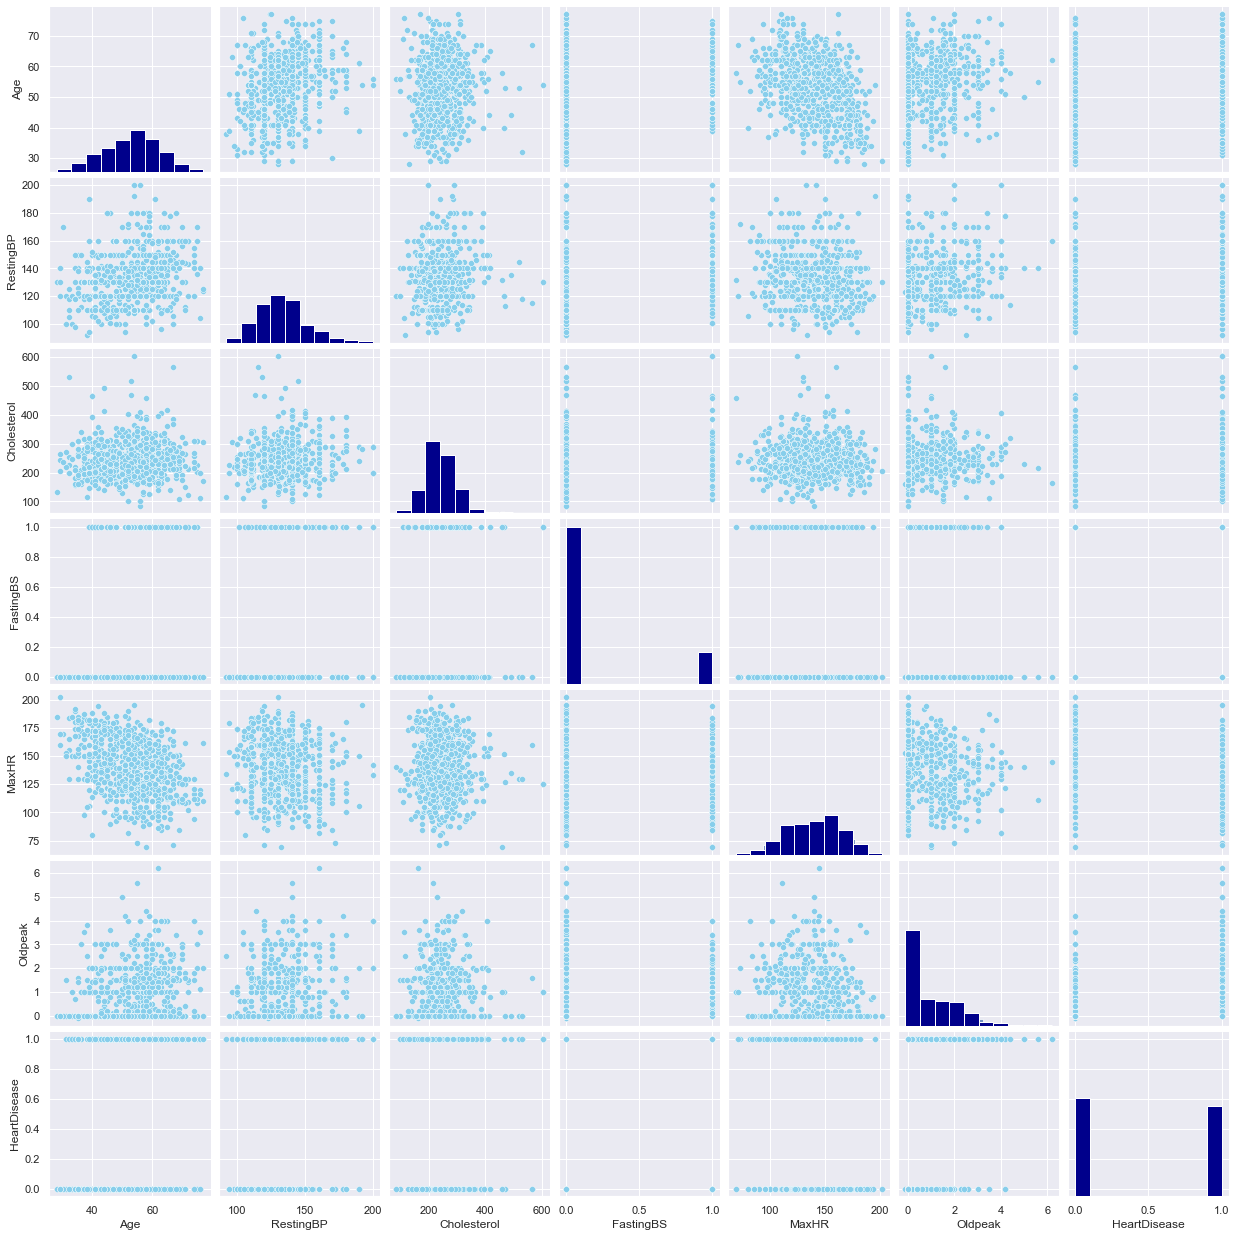

In [19]:
sns.set(palette="vlag")
fig2 = plt.figure()
fig.set_size_inches(10, 6)
sns.set()
cols = df_clean.columns
g = sns.pairplot(df_clean, height = 2.5, diag_kind="hist")
g.map_upper(sns.scatterplot, color='skyblue')
g.map_lower(sns.scatterplot, color='skyblue')
g.map_diag(plt.hist, color='darkblue')
    #plt.title(f"{day} - payment joint distributions")
plt.show();

We note that the maximal heart rate is higher when the age is younger, which imply negative correlation. 

### Heat map for having heart disease

Text(0.5, 1.0, 'correlation between different variables')

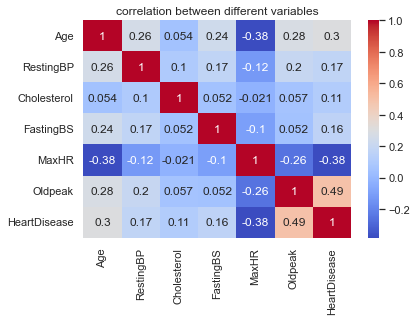

In [20]:
g = sns.heatmap(df_clean.corr(),annot=True,cmap="coolwarm")
plt.title('correlation between different variables')

### Insights from the heatmap:
- No high correlation observed between two features, including 'heartdisease' and the others.
- A positive correlation between Oldpeak and heart failure, as well as between Age and heart failure. These two positive correlations are observed in researh. 
- There is a small correlation between Cholesterol and HeartDisease. Research indicate positive correlation indeed. 
- A small negative correlation between MaxHR and HeartDisease. This means that as the maximal heart rate decrease, HeartDiseas increase, meaning there is a better chance of heaving a heart failure. As before, this is also observed in research. 
- A small negative corelation between MaxHR and Age - as the age increase, maxHR (which is the maximal heart rate) decrease. This was viewed in the correlation diagram and is consistent with current research.
- Age and Cholesterol are not correlated in this dataset. Since a positive correlation was found in reasearch, this requires further investigation in the future.


#### Correlation between 'HeartDisease' and two other variables - plotting heatmaps given the output of 'HeartDisease'
Given the value of 'HeartDisease', two heat maps are drawn. The purpose of this is to try find correlation between 3 features, 'HeartDisease' included. 

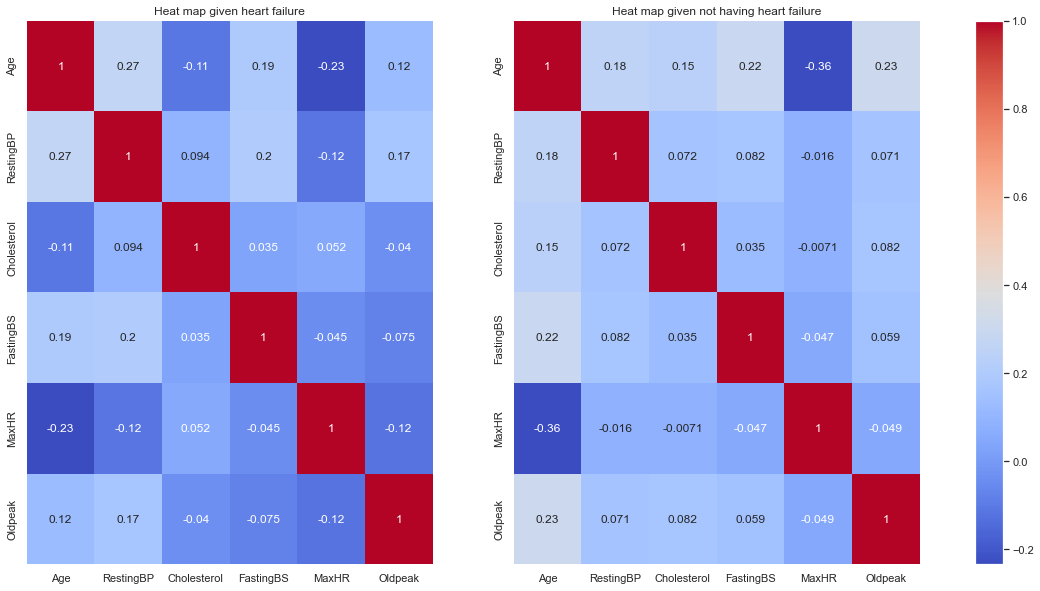

In [21]:
fig, ax =plt.subplots(1, 2, figsize=(20, 10))

# Heat map for having heartdeseas
dfHeartDiseas = df_clean[df_clean['HeartDisease'] == 1]
dfHeartDiseas = dfHeartDiseas.drop('HeartDisease', 1)
ax[0] = sns.heatmap(dfHeartDiseas.corr(), cmap="coolwarm", ax=ax[0], annot=True, cbar=False)
ax[0].set_title('Heat map given heart failure')


# Heat map for not having heartdeseas
dfNo_HeartDiseas = df_clean[df_clean['HeartDisease'] == 0]
dfNo_HeartDiseas = dfNo_HeartDiseas.drop('HeartDisease', 1)
ax[1] = sns.heatmap(dfNo_HeartDiseas.corr(), cmap="coolwarm", ax=ax[1], annot=True, cbar=False)
ax[1].set_title('Heat map given not having heart failure')
#plt.subplots_adjust(left=1, bottom=0.1, right=2, top=0.7, wspace=2, hspace=None)

# setting one color map 
mappable = ax[0].get_children()[0]
plt.colorbar(mappable, ax = [ax[0],ax[1]])

plt.show()



### Insights from the heatmaps:  
1. There is a difference between the two heatmaps, in the correlation between Age and MaxHR (negative correlation), and Age and Oldpeak (positive correlation). This imply a correlation between them and heart failure. 
3. The negative correlation between MaxHR and age remain almost the same, in the absence of heart failure. When heart failure is presence, there is still a negative correlation, but smaller. This imply some correlation between the three features. A correlation between the maxHR and heart failure is also viewed in the regular heat map. 
4. There is a differenc between the two heatmaps, in the correlation between Oldpeak and other features, as well as between RestingBP and other features, and between MaxHR and some of the features. A correlation between Oldpeak in heart failure was observed in the heatmap before.

# Conclusions 
To sum the observation, we can see that
1. The ratio of heaving and not heaving heart failure in the data in not bias (even though it is not completely even).
2. Men are more prone to have heart failure.
3. Heart failure is more probable as the age increase.
4. There is small positive connection between Oldpeak and heart failure.
5. There is a small negative correlation between MaxHT and Age, MaxHR and HeartDisease and the three of them. 
6. There is a small negative correlation between FeastingBS, Cholesterol and HeartDisease.
7. There is a small negative correlation between FeastingBS, Age and HeartDisease.

Some of the observation above, like the connection of heart failure with age, sex and oldpeak, are consistence with research. 